# Library import and data loading

* Dodać gdzie ile obserwacji ucinamy (zarówno dla użytkowników i przedmiotów).
* Zobaczyć na jakich danych działamy po zmniejszeniu agresji ucinania outlierów

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
import scipy.sparse as sp
from scipy import stats
from libreco.data import random_split, DatasetPure, split_by_ratio_chrono
from libreco.algorithms import LightGCN
from libreco.evaluation import evaluate



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv("C:\\Users\\marci\\OneDrive\\Pulpit\\archive\\interactions.csv",
                 # "C:\\Users\\fpazi\\Desktop\\projekty\\olx\\interactions.csv",
                 sep=',')

# from google.colab import drive
# drive.mount("/content/drive")
# df = pd.read_csv("/content/drive/MyDrive/WB_OLX/interactions.csv")

# EDA

## Basic statistics

In [3]:
df['event'].value_counts()

event
click                    58817263
contact_phone_click_1     1721338
bookmark                  1644602
chat_click                1399051
contact_chat               948470
contact_partner_click      459305
contact_phone_click_2      444497
contact_phone_click_3       67675
Name: count, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65502201 entries, 0 to 65502200
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 2.0+ GB


In [5]:
n_users = df['user'].nunique()
n_items = df['item'].nunique()

print('Number of users: ', n_users)
print('Number of items: ', n_items)

Number of users:  3295942
Number of items:  185395


In [6]:
n_events_per_user = df.groupby('user').size()
n_events_per_item = df.groupby('item').size()

print('Average number of events per user: ', round(np.mean(n_events_per_user), 2), ' with a standard deviation of ', np.std(n_events_per_user))
print('Average number of events per item: ', round(np.mean(n_events_per_item), 2), ' with a standard deviation of ', np.std(n_events_per_item))

Average number of events per user:  19.87  with a standard deviation of  47.762363188402105
Average number of events per item:  353.31  with a standard deviation of  624.7732106025969


In [7]:
print('Median number of events per user: ', round(np.median(n_events_per_user), 2))
print('Median number of events per item: ', round(np.median(n_events_per_item), 2))

Median number of events per user:  6.0
Median number of events per item:  137.0


## Number of interactions per user

In [8]:
n_events_per_user.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
dtype: float64

[Text(0.5, 1.0, 'ECDF of number of interactions per user')]

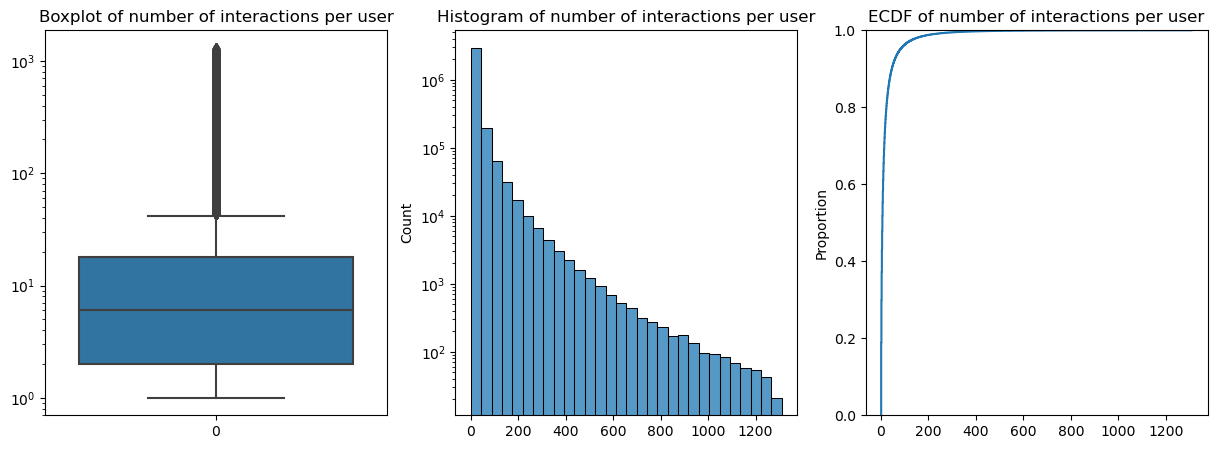

In [9]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
h1 = sns.boxplot(n_events_per_user, ax=axs[0])
h1.set_yscale('log')
h1.set(title = 'Boxplot of number of interactions per user')
h2=sns.histplot(n_events_per_user, bins=30, ax=axs[1])
h2.set_yscale('log')
h2.set(title = 'Histogram of number of interactions per user')
h3 = sns.ecdfplot(n_events_per_user)
h3.set(title = 'ECDF of number of interactions per user')

We have used the logarithmic scale for the box and histogram plot.

## Number of interactions per item

In [10]:
n_events_per_item.describe()

count    185395.000000
mean        353.311583
std         624.774896
min           1.000000
25%           3.000000
50%         137.000000
75%         428.000000
max       15480.000000
dtype: float64

[Text(0.5, 1.0, 'ECDF of number of interactions per item')]

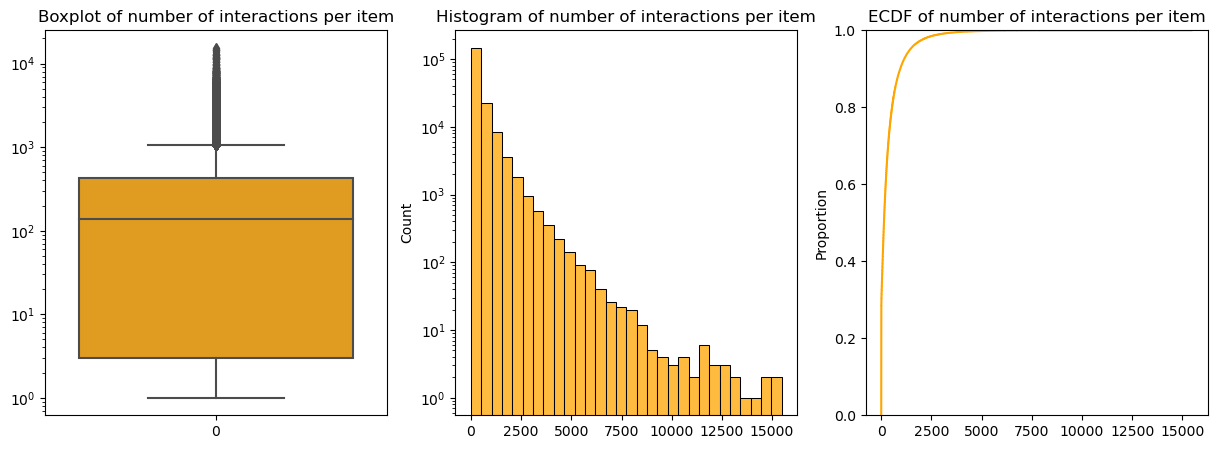

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
h1 = sns.boxplot(n_events_per_item, ax=axs[0], color='orange')
h1.set_yscale('log')
h1.set(title = 'Boxplot of number of interactions per item')
h2=sns.histplot(n_events_per_item, bins=30, ax=axs[1], color='orange')
h2.set_yscale('log')
h2.set(title = 'Histogram of number of interactions per item')
h3 = sns.ecdfplot(n_events_per_item, color='orange')
h3.set(title = 'ECDF of number of interactions per item')

We have used the logarithmic scale for the box and histogram plot.

# Data pre-processing

Split the values from the `event` column so that we can tailor our data frame to the task.

In [12]:
rating = {
    'click': 1,
    'bookmark': 2,
    'chat_click': 3,
    'contact_phone_click_1': 3,
    'contact_partner_click': 3,
    'contact_phone_click_2': 3,
    'contact_phone_click_3': 3,
    'contact_chat': 3
}
df['event'] = df['event'].map(rating)
df = df.rename(columns={'event': 'label'})
df = df.rename(columns={'timestamp': 'time'})

In [13]:
user_interaction_counts = df['user'].value_counts()
user_interaction_counts.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
Name: count, dtype: float64

We get rid of users with less than 100 interactions. In this way, we hope to weed out users who are not regulars. <br>We get rid of outliers using the 8 sigma method.

In [14]:
reg_users = user_interaction_counts[user_interaction_counts >= 100]
users_to_keep = reg_users[reg_users <= reg_users.mean() + 8*reg_users.std()].index
df_no = df[df['user'].isin(users_to_keep)]

In [15]:
n_events_per_user = df_no.groupby('user').size()
n_events_per_user.describe()

count    123531.000000
mean        202.475403
std         134.874360
min         100.000000
25%         121.000000
50%         156.000000
75%         229.000000
max        1283.000000
dtype: float64

In [16]:
df_no['user'].nunique()/n_users

0.03747972506797753

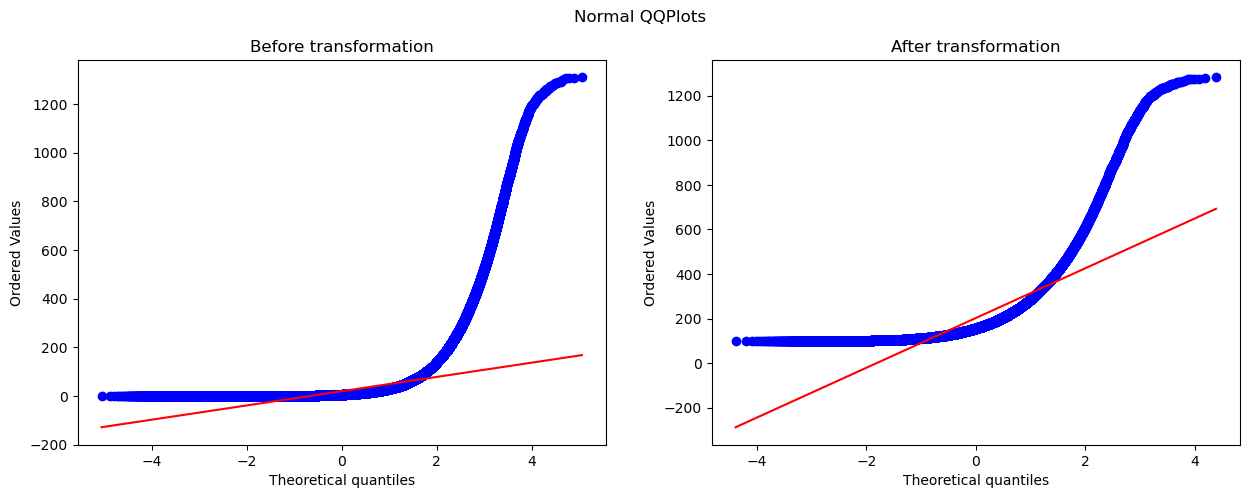

In [17]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))
stats.probplot(user_interaction_counts, dist='norm', plot=axis[0])
axis[0].set_title("Before transformation")

stats.probplot(n_events_per_user, dist='norm', plot=axis[1])
axis[1].set_title("After transformation")

figure.suptitle("Normal QQPlots")
plt.show()

Text(0.5, 1.0, 'Boxplot of interactions per user.')

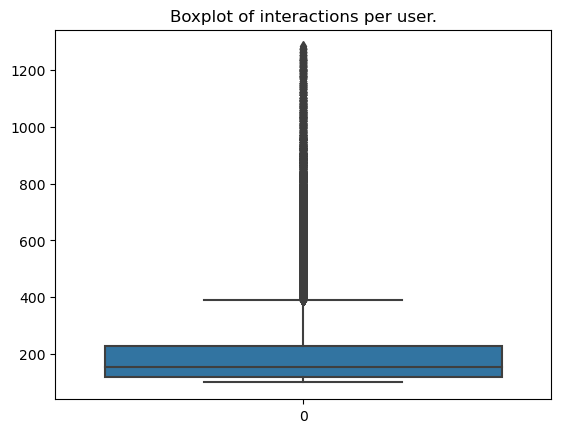

In [18]:
sns.boxplot(n_events_per_user.values).set_title('Boxplot of interactions per user.')

We will again apply the log scale to the y axis to see the distribution more clrealy.

[Text(0.5, 1.0, 'Histogram of number of interactions per user')]

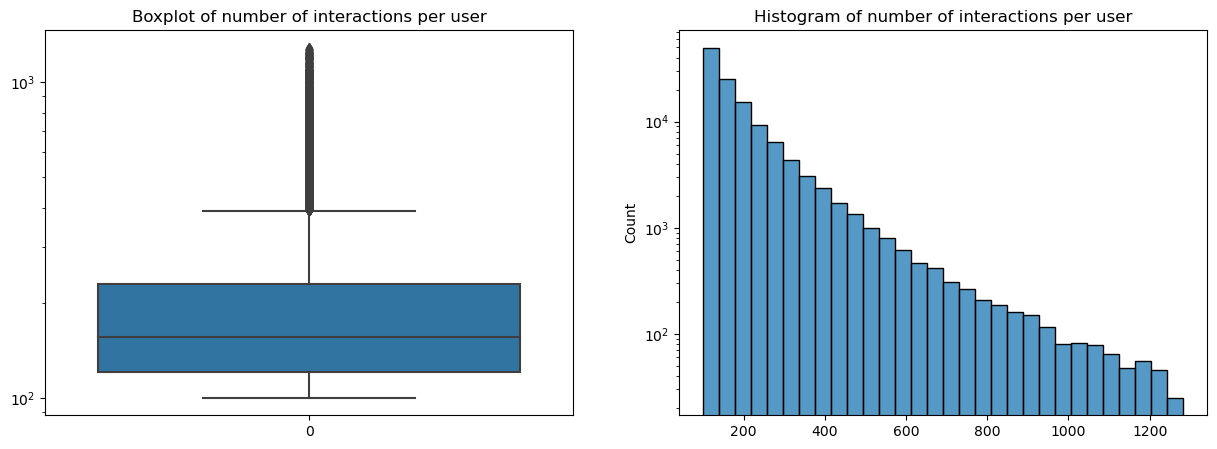

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
h1 = sns.boxplot(n_events_per_user.values, ax=axs[0])
h1.set_yscale('log')
h1.set(title = 'Boxplot of number of interactions per user')
h2=sns.histplot(n_events_per_user, bins=30, ax=axs[1])
h2.set_yscale('log')
h2.set(title = 'Histogram of number of interactions per user')

Here we try to label less users as outliers. We decided that users with no interactions are not interesting in our model, and users with more than 1000 interactions in two weeks might be bots so we deleted them. This resulted in using more than 99% of the original number of users. The idea is to compare two models, one created on smaller but maybe more dense training set and then the second one created on bigger, less dense training set and compare the metrics on the same test set.

In [75]:
user_interaction_counts = df['user'].value_counts()
reg_users = user_interaction_counts[user_interaction_counts >= 1]
users_to_keep = reg_users[reg_users <= 1000].index
df_fil = df[df['user'].isin(users_to_keep)]

In [76]:
df_fil['user'].nunique()/n_users

0.9998707501527636

In [60]:
n_events_per_user = df_fil.groupby('user').size()
n_events_per_user.describe()

count    3.295516e+06
mean     1.973114e+01
std      4.608337e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.000000e+03
dtype: float64

We get rid of items with fewer than 1,000 interactions. In doing so, we hope to retain items that enjoy at least moderate success. <br>We get rid of outliers using the 8 sigma method.

In [23]:
item_interaction_counts = df_no['item'].value_counts()

In [24]:
item_interaction_counts.describe()

count    145085.000000
mean        172.395416
std         298.115472
min           1.000000
25%          23.000000
50%          74.000000
75%         195.000000
max        7276.000000
Name: count, dtype: float64

In [25]:
popular_item = item_interaction_counts[item_interaction_counts >= 1000]
items_to_keep = popular_item[popular_item <= popular_item.mean() + 8*popular_item.std()].index
df_no = df_no[df_no['item'].isin(items_to_keep)].reset_index(drop=True)

In [26]:
df_no['item'].nunique()/n_items

0.017745893902208796

In [27]:
n_events_per_item = df_no.groupby('item').size()
n_events_per_item.describe()

count    3290.000000
mean     1577.923100
std       693.458523
min      1000.000000
25%      1139.000000
50%      1355.000000
75%      1754.000000
max      7080.000000
dtype: float64

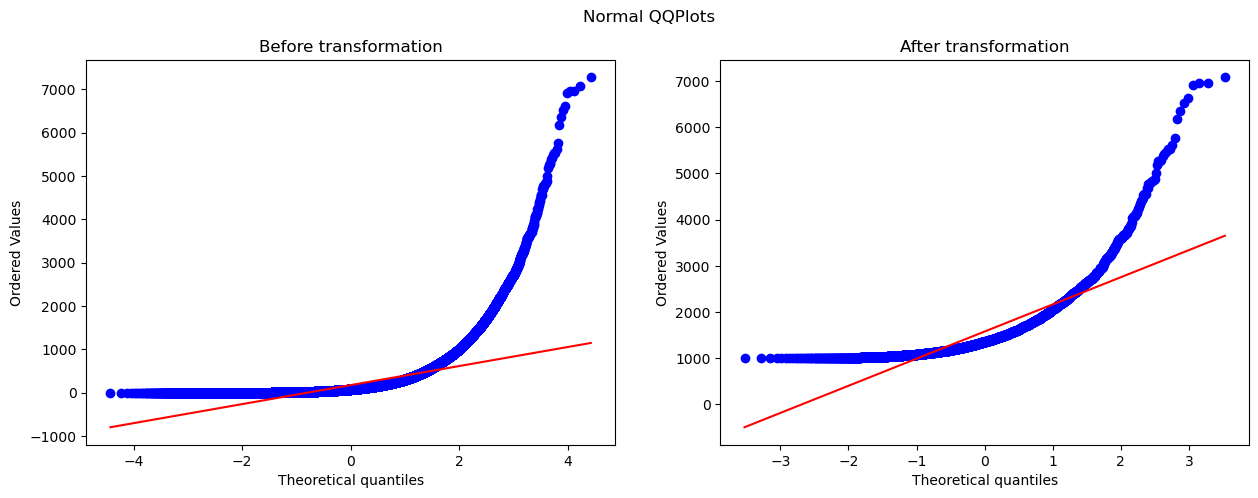

In [28]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))
stats.probplot(item_interaction_counts, dist='norm', plot=axis[0])
axis[0].set_title("Before transformation")

stats.probplot(n_events_per_item, dist='norm', plot=axis[1])
axis[1].set_title("After transformation")

figure.suptitle("Normal QQPlots")
plt.show()

Text(0.5, 1.0, 'Boxplot of interactions per item.')

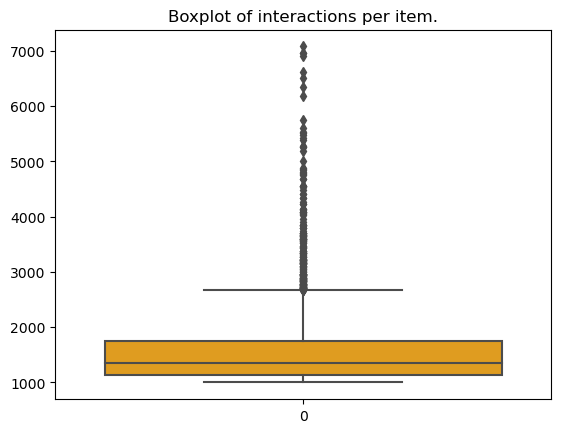

In [29]:
sns.boxplot(n_events_per_item.values, color='orange').set_title("Boxplot of interactions per item.")

Once again, we can apply the log scale to the y axis to get a better idea of the distribution.

KeyError: 0

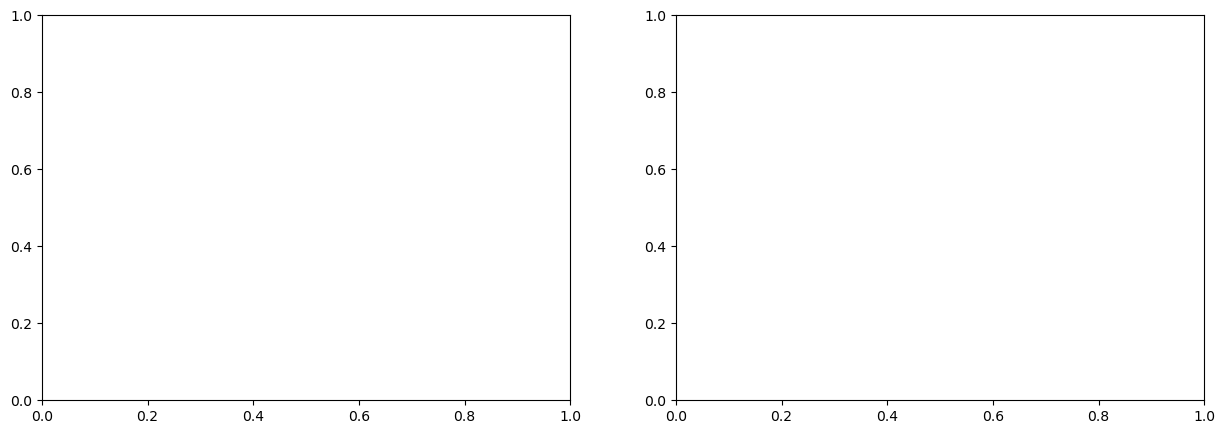

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
h1 = sns.boxplot(n_events_per_item, ax=axs[0], color='orange')
h1.set_yscale('log')
h1.set(title = 'Boxplot of number of interactions per item')
h2=sns.histplot(n_events_per_item.values, bins=30, ax=axs[1], color='orange')
h2.set_yscale('log')
h2.set(title = 'Histogram of number of interactions per item')

We do not have to do any outliers filtering for items. We will filter outliers that are items with 0 interactions using top 20% of items with the most interactions, and very high number of interactions in items is more realistic than users, item might be very popular or shown to almost every user of the app.

In [71]:
item_interaction_counts = df_fil['item'].value_counts()
item_interaction_counts.describe()

count    185327.000000
mean        350.862524
std         619.646507
min           1.000000
25%           4.000000
50%         136.000000
75%         425.000000
max       15455.000000
Name: count, dtype: float64

In [77]:
df_fil['item'].nunique()/n_items

0.9996332155667629

 First filtering of the data frame. We select the 20% of users with the highest number of interactions. First we do this for the dataset with soft outliers.

In [78]:
item_interaction_counts = df_fil['item'].value_counts()

top_20_threshold = item_interaction_counts.quantile(0.8)

top_20_items = item_interaction_counts[item_interaction_counts >= top_20_threshold].index

filtered_df = df_fil[df_fil['item'].isin(top_20_items)]

In [79]:
item_interaction_counts = filtered_df['item'].value_counts()
count_items = filtered_df['item'].nunique()

item_interaction_counts.describe()
print(f"Ratio of items before and after filtering: {count_items/n_items * 100}")

Ratio of items before and after filtering: 20.000539388872408


In [80]:
user_interaction_counts = filtered_df['user'].value_counts()

top_20_threshold = user_interaction_counts.quantile(0.8)

top_20_users = user_interaction_counts[user_interaction_counts >= top_20_threshold].index

filtered_df = filtered_df[filtered_df['user'].isin(top_20_users)]

In [81]:
user_interaction_counts = filtered_df['user'].value_counts()
count_users = filtered_df['user'].nunique()

user_interaction_counts.describe()
print(f"Ratio of users before and after filtering: {count_users/n_users * 100}")

Ratio of users before and after filtering: 18.423867895733604


We do the same for items.

We compare the ratio of items/users in the input data frame and the filtered one. As we can see, the ratio is almost identical.

In [82]:
count_users_before = df['user'].nunique()
count_items_before = df['item'].nunique()
count_users = filtered_df['user'].nunique()
print(f"Number of users: {count_users}")
count_items = filtered_df['item'].nunique()
print(f"Number of items: {count_items}")
print(f"Ratio of items to users after filtering: {count_items/count_users * 100}")
print(f"Ratio of items to users before filtering: {count_items_before/count_users_before * 100}")

Number of users: 607240
Number of items: 37080
Ratio of items to users after filtering: 6.1063171069099536
Ratio of items to users before filtering: 5.624947283659725


Another filtering of the data frame.<br>
Now we randomly select $x\% $ of unique objects and users so that the machines we are working on do not have memory problems.

In [83]:
sample_percent_users = 0.12
sample_percent_items = 0.1

sampled_users = filtered_df.drop_duplicates('user').sample(frac=sample_percent_users, random_state=2024)

sampled_items = filtered_df.drop_duplicates('item').sample(frac=sample_percent_items, random_state=2024)

filtered_df_users = filtered_df[filtered_df['user'].isin(sampled_users['user'])]

filtered_df = filtered_df_users[filtered_df_users['item'].isin(sampled_items['item'])]

Again, let's check the item/user ratio.

In [84]:
count_users = filtered_df['user'].nunique()
print(f"Number of users: {count_users}")
count_items = filtered_df['item'].nunique()
print(f"Number of items: {count_items}")
print(f"Ratio of items to users after filtering: {count_items/count_users * 100}")
print(f"Ratio of items to users before filtering: {count_items_before/count_users_before * 100}")
print(f"Percent of items: {count_items/n_items * 100}")
print(f"Percent of users: {count_users/n_users * 100}")

Number of users: 65850
Number of items: 3708
Ratio of items to users after filtering: 5.630979498861048
Ratio of items to users before filtering: 5.624947283659725
Percent of items: 2.0000539388872407
Percent of users: 1.9979113710132037


Now, we will do the same for the heavy filtered dataset.

In [85]:
item_interaction_counts = df_no['item'].value_counts()

top_20_threshold = item_interaction_counts.quantile(0.8)

top_20_items = item_interaction_counts[item_interaction_counts >= top_20_threshold].index

filtered_df_no = df_no[df_no['item'].isin(top_20_items)]

item_interaction_counts = filtered_df_no['item'].value_counts()
count_items = filtered_df_no['item'].nunique()

item_interaction_counts.describe()
print(f"Ratio of items before and after filtering: {count_items/n_items * 100}")

Ratio of items before and after filtering: 0.35491787804417596


In [86]:
user_interaction_counts = filtered_df_no['user'].value_counts()

top_20_threshold = user_interaction_counts.quantile(0.8)

top_20_users = user_interaction_counts[user_interaction_counts >= top_20_threshold].index

filtered_df_no = filtered_df_no[filtered_df_no['user'].isin(top_20_users)]

user_interaction_counts = filtered_df_no['user'].value_counts()
count_users = filtered_df_no['user'].nunique()

user_interaction_counts.describe()
print(f"Ratio of users before and after filtering: {count_users/n_users * 100}")

Ratio of users before and after filtering: 0.7292907460143413


In [87]:
count_users_before = df['user'].nunique()
count_items_before = df['item'].nunique()
count_users = filtered_df_no['user'].nunique()
print(f"Number of users: {count_users}")
count_items = filtered_df_no['item'].nunique()
print(f"Number of items: {count_items}")
print(f"Ratio of items to users after filtering: {count_items/count_users * 100}")
print(f"Ratio of items to users before filtering: {count_items_before/count_users_before * 100}")

Number of users: 24037
Number of items: 658
Ratio of items to users after filtering: 2.7374464367433538
Ratio of items to users before filtering: 5.624947283659725


The filtering is heavy enough so we can use the whole filtered dataframe for creating the model.

# Creating the model

We implement code from the LibRecommender library that divides the data into a training, evaluation and test sets. We begin with dataframe using soft filtering.

In [105]:
train_data, eval_data, test_data = split_by_ratio_chrono(filtered_df,multi_ratios=[0.7,0.1,0.2])
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 65850, n_items: 3708, data density: 0.1283 %


In [89]:
best_lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="bpr",
    embed_size=32,
    n_epochs=3,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

In [90]:
%%time
best_lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=0,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

Training start time: 2024-03-11 12:31:51
CPU times: total: 4min 28s
Wall time: 1min 23s


In [91]:
%%time
results_best = evaluate(
    model=best_lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)
results_best

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 481.42it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|███████████████████████████████████████████████████████████| 18149/18149 [00:03<00:00, 5043.17it/s]


CPU times: total: 15.3 s
Wall time: 4.62 s


{'loss': 0.539128198823804,
 'roc_auc': 0.8802215423071618,
 'precision': 0.015480191746101712,
 'recall': 0.09752046078703194,
 'ndcg': 0.07583312991454273,
 'map': 0.05474761648558146}

The result above are the results we were asked to find, k=10 which is default for the package. Below we explored different values of k to see how the results change. We also tried using different recommended loss functions and different learning rate. It is important to note that the problem we had last week, loss function increasing with further epochs, was connected with the learning rate. If the learning rate was too big the loss function started to increase. We found that learning rate lr=1e-3 is the most optimal tradeoff between not increasing loss function and best results.

In [92]:
loss_function = "bpr"

metrics = ["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
k_values = [50, 20, 10, 5, 3, 1]

results_df = pd.DataFrame(index=pd.MultiIndex.from_product([k_values]), columns=metrics)

for k in k_values:
    results = evaluate(
        model=best_lightgcn,
        data=test_data,
        neg_sampling=True,
        metrics=metrics,
        k=k
    )
    for metric, value in results.items():
        results_df.at[k, metric] = value

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 590.71it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 578.01it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 591.52it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps par

In [93]:
results_df

,loss,precision,recall,ndcg,map,roc_auc
50,0.539128,0.007944,0.239554,0.115621,0.059762,0.880222
20,0.539128,0.012078,0.149865,0.09337,0.058437,0.880222
10,0.539128,0.01548,0.09752,0.075833,0.054748,0.880222
5,0.539128,0.01891,0.060498,0.05904,0.048559,0.880222
3,0.539128,0.021966,0.042375,0.048293,0.042789,0.880222
1,0.539128,0.027109,0.017887,0.027109,0.027109,0.880222


In [94]:
loss_functions = ["max_margin","cross_entropy", "focal"]
metrics = ["loss", "precision", "recall", "ndcg", "map", "roc_auc"]

results_df = pd.DataFrame(index=loss_functions, columns=metrics)

for loss_func in loss_functions:
    lossgcn = LightGCN(
        task="ranking",
        data_info=data_info,
        loss_type=loss_func,
        embed_size=32,
        n_epochs=3,
        lr=1e-3,
        batch_size=2048,
        num_neg=1,
        device="cuda"
    )
    lossgcn.fit(
        train_data,
        neg_sampling=True,
        verbose=0,
        eval_data=eval_data,
        metrics=["loss", "precision", "recall", "ndcg", "map"]
    )
    evaluate(
        model=lossgcn,
        data=test_data,
        neg_sampling=True,
        metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
    )
    results = evaluate(
        model=lossgcn,
        data=test_data,
        neg_sampling=True,
        metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
    )
    for metric, value in results.items():
        results_df.at[loss_func, metric] = value

Training start time: 2024-03-11 12:33:46


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 475.02it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 501.95it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|███████████████████████████████████████████████████████████| 18149/18149 [00:03<00:00, 4873.88it/s]


Training start time: 2024-03-11 12:35:17


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 493.77it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 550.53it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|███████████████████████████████████████████████████████████| 18149/18149 [00:03<00:00, 5035.51it/s]


Training start time: 2024-03-11 12:38:16


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 462.83it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 604.63it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|███████████████████████████████████████████████████████████| 18149/18149 [00:03<00:00, 5108.06it/s]


In [95]:
for metric, value in results_best.items():
    results_df.at['bpr', metric] = value
results_df

,loss,precision,recall,ndcg,map,roc_auc
max_margin,0.548997,0.01645,0.104145,0.080671,0.058299,0.883261
cross_entropy,0.509921,0.015921,0.100795,0.078638,0.057043,0.883265
focal,0.621021,0.014866,0.092915,0.072714,0.052521,0.871172
bpr,0.539128,0.01548,0.09752,0.075833,0.054748,0.880222


Now, we do the same for dataframe with heavy filtering. To save some time, we will not run the model using all loss functions and different values of k.

In [112]:
train_data1, eval_data1, test_data1 = split_by_ratio_chrono(filtered_df_no,multi_ratios=[0.7,0.1,0.2])
train_data1, data_info1 = DatasetPure.build_trainset(train_data1)
eval_data1 = DatasetPure.build_evalset(eval_data1)
test_data1 = DatasetPure.build_testset(test_data1)
print(data_info1)

n_users: 24037, n_items: 658, data density: 4.7238 %


In [102]:
%%time
lightgcnH = LightGCN(
    task="ranking",
    data_info=data_info1,
    loss_type="bpr",
    embed_size=32,
    n_epochs=3,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

lightgcnH.fit(
    train_data1,
    neg_sampling=True,
    verbose=0,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

Training start time: 2024-03-11 12:57:06


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 565.20it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 2004/2004 [00:01<00:00, 1641.32it/s]


CPU times: total: 13min 48s
Wall time: 3min 56s


{'loss': 0.535148234330126,
 'roc_auc': 0.8946096053939663,
 'precision': 0.053654782210758416,
 'recall': 0.09204379704893069,
 'ndcg': 0.21000116587262194,
 'map': 0.1498038167567178}

In [104]:
lightgcnH.save(
        path="model_path", model_name="lightgcnH", manual=True, inference_only=False
    )

file folder model_path doesn't exists, creating a new one...


In [113]:
train_data_new, _ = train_test_split(filtered_df, test_size=0.5)

In [114]:
train_data2, new_data_info = DatasetPure.merge_trainset(train_data_new, data_info1, merge_behavior=True)
print(new_data_info)

n_users: 77488, n_items: 4295, data density: 0.0627 %


In [117]:
lightgcnH.rebuild_model(path="model_path", model_name="lightgcnH", full_assign=True)

TypeError: rebuild_torch_model() got an unexpected keyword argument 'full_assign'

# Additional task

Dataframe containing users and an array of items they have interacted with.

In [ ]:
df_all = filtered_df.groupby('user')['item'].apply(list).reset_index(name='items')
df_all = df_all.sort_values(by='user')

Dataframe containing users and an array of items with which they have interacted at a higher level.

In [ ]:
df_23 = filtered_df[filtered_df['label'].isin([2, 3])].groupby('user')['item'].apply(list).reset_index(name='items')
all_users = filtered_df[['user']].drop_duplicates()
df_23 = pd.merge(all_users, df_23, on='user', how='left')
df_23['items'] = df_23['items'].apply(lambda x: x if isinstance(x, list) else [])
df_23 = df_23.sort_values(by='user')

Dataframe containing users and an array of items that are recommended to them.

In [ ]:
unique_users = filtered_df['user'].unique()
recommendations_data = []

Recommendations for each user.

In [ ]:
for user in unique_users:
    recommendations = best_lightgcn.recommend_user(user=user, n_rec=10).get(user)
    recommendations_data.extend([(user, recommendations)])

df_rec = pd.DataFrame(recommendations_data, columns=['user', 'items'])
df_rec = df_rec.sort_values(by='user')


In [ ]:
def find_intersection(row, df):
    rec_items = row['items']
    all_items = df.loc[df['user'] == row['user'], 'items'].values
    if len(rec_items) == 0 or len(all_items) == 0:
        return []
    else:
        intersection = np.intersect1d(rec_items, all_items[0])
        return intersection

Restriction of recommended items to those with which the user has had any interaction.

In [ ]:
df_rec['items'] = df_rec.apply(lambda row: find_intersection(row, df_all), axis=1)

df_match = df_rec.copy()

Listing of items both recommended and those with which the user has had higher-level interaction.

In [ ]:
df_match['items'] = df_match.apply(lambda row: find_intersection(row, df_23), axis=1)

`precision`

In [ ]:
(df_match['items'].apply(len)/df_rec['items'].apply(len)).sum(skipna=True)/len(df_match['items'])

In [ ]:
sns.histplot(df_match['items'].apply(len)/df_rec['items'].apply(len))

`recall`

In [ ]:
(df_match['items'].apply(len)/df_23['items'].apply(len)).sum(skipna=True)/len(df_match['items'])

In [ ]:
sns.histplot(df_match['items'].apply(len)/df_23['items'].apply(len))